# Tryouts with tensorflow with tensorpack

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import cv2 

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
import numpy as np
from sklearn.model_selection import KFold

from common.data_utils import train_ids, test_ids, UNIQUE_TRAIN_CAR_MAKERS, get_trainval_data_ids, OUTPUT_PATH, GENERATED_DATA
from common.tf.CarvanaDataFlow import CarvanaDataFlow

from common.cv_utils import generate_k_folds_trainval_data_ids

In [4]:
from tensorpack.utils.utils import fix_rng_seed
from tensorpack.dataflow import AugmentImageComponent, AugmentImageComponents, BatchData, PrefetchDataZMQ

In [5]:
from tensorpack.dataflow.imgaug import Resize, Flip, RandomOrderAug, RandomApplyAug, RandomChooseAug, Affine
from tensorpack.dataflow.imgaug import Hue, Saturation, Brightness, Contrast, Gamma
from tensorpack.dataflow.imgaug import MinMaxNormalize, ToFloat32

In [6]:
from tensorpack.dataflow import RepeatedData, SelectComponent
from tensorpack.dataflow.imgaug import AugmentorList, serialize

In [22]:
seed = 12345
batch_size = 16
n_folds = 7

input_shape = (512, 768, 3) 
n_classes = 1

In [16]:
# Train augmenters:
train_geom_augmentors = [
    Resize(shape=input_shape[:-1]),    
    RandomOrderAug([
        Flip(horiz=True, prob=0.5),
        Flip(vert=True, prob=0.5),    
        RandomApplyAug(
                Affine(scale=(0.8, 2.0), 
                       translate_frac=(0.15, 0.15), 
                       rotate_max_deg=45.0, 
                       shear=15.0, 
                       border=cv2.BORDER_REPLICATE, border_value=0.0),
                prob=0.75
        ),        
    ])    
]

train_color_augmentors = [
    ToFloat32(),
    MinMaxNormalize(min=0.0, max=1.0), 
    RandomChooseAug([
        RandomApplyAug(Hue(rgb=True), prob=0.5), 
        RandomApplyAug(Saturation(rgb=True), prob=0.5),    
    ]),    
    RandomChooseAug([
        RandomApplyAug(Brightness(delta=0.75), prob=0.5),
        RandomApplyAug(Contrast(factor_range=(0.25, 1.75)), prob=0.5),
    ]),
]

# Validation augmenters:
val_geom_augmentors = [
    Resize(shape=input_shape[:-1]),    
    RandomOrderAug([
        Flip(horiz=True, prob=0.5),
        Flip(vert=True, prob=0.5),    
    ])    
]

val_color_augmentors = [
    ToFloat32(),
    MinMaxNormalize(min=0.0, max=1.0), 
]


def get_train_aug_batchs_gen(train_ds, batch_size, geom_augmentors, color_augmentors, use_zmq=False):
    geomaug_ds = AugmentImageComponents(train_ds, geom_augmentors, copy=False)
    geomcoloraug_ds = AugmentImageComponent(geomaug_ds, color_augmentors, index=0, copy=False)    
    inf_geomcoloraug_ds = RepeatedData(geomcoloraug_ds, nr=-1)
    batchs = BatchData(inf_geomcoloraug_ds, batch_size=batch_size, use_list=True, remainder=True)
    if use_zmq:
        batchs = PrefetchDataZMQ(batchs, nr_proc=5)
    return batchs


def get_val_aug_batchs_gen(val_ds, batch_size, geom_augmentors, color_augmentors, use_zmq=False):    
    geomaug_ds = AugmentImageComponents(val_ds, geom_augmentors, copy=False)
    geomcoloraug_ds = AugmentImageComponent(geomaug_ds, color_augmentors, index=0, copy=False)    
    batchs = BatchData(geomcoloraug_ds, batch_size=batch_size, use_list=True, remainder=True)    
    if use_zmq:
        batchs = PrefetchDataZMQ(batchs, nr_proc=5)
    return batchs

## Check train/validation data flow

In [17]:
batch_size=3

fix_rng_seed(seed)
gen = generate_k_folds_trainval_data_ids(n_folds=n_folds)

for train_data_ids, val_data_ids in gen:
        
    train_ds = CarvanaDataFlow(data_ids=train_data_ids, with_y=True, shuffle=True, max_n_samples=5)
    val_ds = CarvanaDataFlow(data_ids=val_data_ids, with_y=True, shuffle=True, max_n_samples=5)
    
    train_batchs = get_train_aug_batchs_gen(train_ds, 
                                            batch_size=batch_size, 
                                            geom_augmentors=train_geom_augmentors,
                                            color_augmentors=train_color_augmentors)
    
    val_batchs = get_val_aug_batchs_gen(val_ds, 
                                        batch_size=batch_size,
                                        geom_augmentors=val_geom_augmentors,
                                        color_augmentors=val_color_augmentors)
       
    
    break
    

In [18]:
import matplotlib.pylab as plt
%matplotlib inline

In [19]:
from common.image_utils import scale_percentile

3 (512, 768, 3) (512, 768, 1)
float32 uint8
0.0 1.0 0 1
3 (512, 768, 3) (512, 768, 1)
float32 uint8
0.0 0.724563 0 1
3 (512, 768, 3) (512, 768, 1)
float32 uint8
0.310861 0.840028 0 1
3 (512, 768, 3) (512, 768, 1)
float32 uint8
0.0 1.0 0 1
3 (512, 768, 3) (512, 768, 1)
float32 uint8
0.0 0.525878 0 1


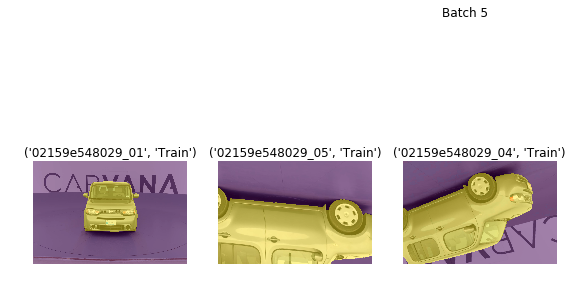

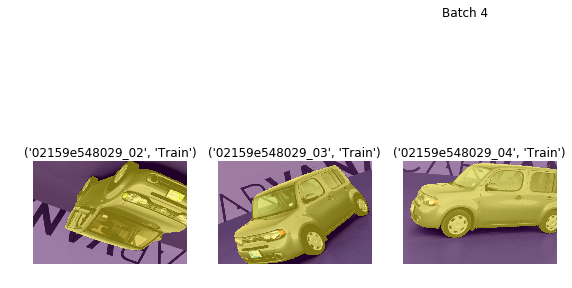

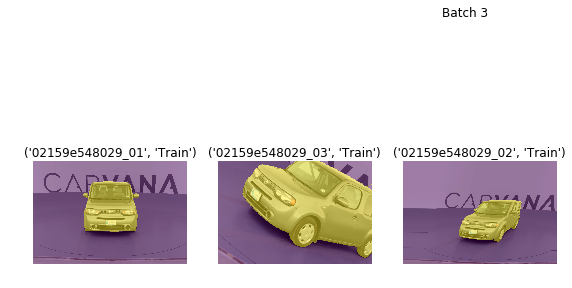

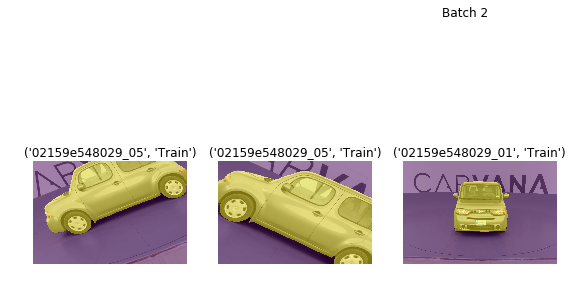

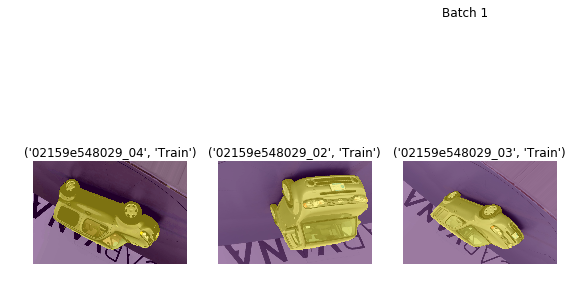

In [20]:
loop_max_counter = 5

train_batchs.reset_state()

for batch_imgs, batch_masks, batch_ids in train_batchs.get_data():

    print(len(batch_imgs), batch_imgs[0].shape, batch_masks[0].shape)
    print(batch_imgs[0].dtype, batch_masks[0].dtype)
    print(batch_imgs[0].min(), batch_imgs[0].max(), batch_masks[0].min(), batch_masks[0].max())
    
    n = 5
    s = min(batch_size, len(batch_imgs))
    plt.figure(figsize=(16, 6))
    plt.suptitle("Batch %i" % loop_max_counter)
    for counter in range(s):
        if counter > 0 and counter % n == 0:
            plt.figure(figsize=(16, 16))
        plt.subplot(1, n, counter % n + 1)
        img = scale_percentile(batch_imgs[counter])
        mask = batch_masks[counter][:,:, 0]
        ids = batch_ids[counter]
                        
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        plt.title("{}".format(ids))
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break

3 (512, 768, 3) (512, 768, 1)
float32 uint8
0.0 1.0 0 1
2 (512, 768, 3) (512, 768, 1)
float32 uint8
0.0 1.0 0 1


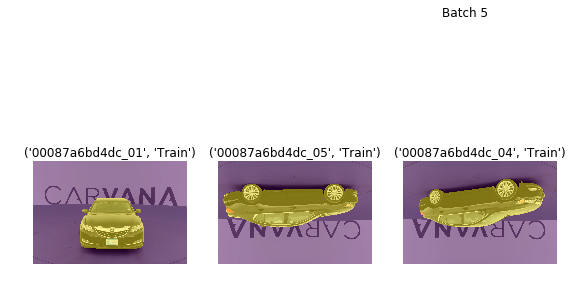

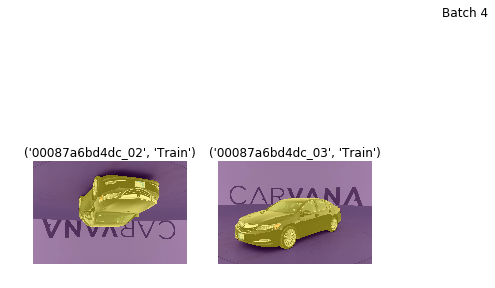

In [21]:
loop_max_counter = 5

val_batchs.reset_state()

for batch_imgs, batch_masks, batch_ids in val_batchs.get_data():

    print(len(batch_imgs), batch_imgs[0].shape, batch_masks[0].shape)
    print(batch_imgs[0].dtype, batch_masks[0].dtype)
    print(batch_imgs[0].min(), batch_imgs[0].max(), batch_masks[0].min(), batch_masks[0].max())
    
    n = 5
    s = min(batch_size, len(batch_imgs))
    plt.figure(figsize=(16, 6))
    plt.suptitle("Batch %i" % loop_max_counter)
    for counter in range(s):
        if counter > 0 and counter % n == 0:
            plt.figure(figsize=(16, 16))
        plt.subplot(1, n, counter % n + 1)
        img = scale_percentile(batch_imgs[counter])
        mask = batch_masks[counter][:,:, 0]
        ids = batch_ids[counter]
                        
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        plt.title("{}".format(ids))
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break

## Define a model

In [35]:
import tensorflow as tf

from tensorpack.graph_builder import ModelDesc, InputDesc
from tensorpack.utils.argtools import memoized
from tensorpack.tfutils import summary, get_global_step_var

In [10]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
from common.tf.keras_unet import get_unet

Using TensorFlow backend.


In [43]:
class UNet(ModelDesc):
    
    def __init__(self, input_shape, n_classes, depth=5, n_filters=32):
        assert isinstance(input_shape, list) or isinstance(input_shape, tuple), \
            "input_shape should be a list or tuple"
        super(UNet, self).__init__()
        self.depth = depth
        self.n_filters = n_filters
        self.input_shape = list(input_shape)
        self.output_shape = self.input_shape[:-1] + [n_classes,]
        self.name = "unet_%ix%i_depth=%i_n_filters=%i" % \
            (input_shape[0],input_shape[1], depth, n_filters) 
        
    def _get_inputs(self):        
        x = InputDesc(tf.float32, [None, ] + self.input_shape, 'input-image') 
        y = InputDesc(tf.float32, [None, ] + self.output_shape, 'output-mask') 
        return [x, y]

    @memoized   # this is necessary for sonnet/Keras to work under tensorpack
    def _build_keras_model(self):
        return get_unet(self.input_shape, 
                        n_classes=self.output_shape[-1], 
                        depth=self.depth, 
                        n_filters=self.n_filters)
    
    def _build_graph(self, inputs):
        image, mask = inputs
        
        unet = self._build_keras_model()
        
        logits = unet(image)
        probas = tf.nn.sigmoid(logits, name='probas')
        
        # define loss function
        
        bce_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=mask)
        bce_loss = tf.reduce_mean(bce_loss, name='bce_loss')  # the average binary cross-entropy loss

        self.cost = tf.identity(bce_loss, name='cost')
        
        # define training metrics:         
        summary.add_moving_summary(self.cost)
        
    def _get_optimizer(self):
        lr = tf.train.exponential_decay(
            learning_rate=1e-3,
            global_step=get_global_step_var(),
            decay_steps=468 * 10,
            decay_rate=0.3, 
            staircase=True, 
            name='learning_rate')
        tf.summary.scalar('lr', lr)
        return tf.train.AdamOptimizer(lr)

## Train model

In [51]:
from tensorpack.utils import logger
from tensorpack.train import TrainConfig, QueueInputTrainer
from tensorpack.callbacks import ModelSaver, MaxSaver, InferenceRunner
from tensorpack.callbacks import InferenceRunner, ScalarStats
from tensorpack.utils.gpu import get_nr_gpu

In [52]:
# monitor_stat = 'val-bce_loss'
# filename = 'model_val-bce_loss={val-bce_loss:.5f}'
# # filename = 'model_val-bce_loss={val-bce_loss}'
# # filename = None
# # filename = 'model'

# value = 0.12345678901234567899

# if filename is not None:
#     if len(re.findall(r'\{%s(?:.+)?\}' % monitor_stat, filename)) > 0:
#         newname = filename.format(**{monitor_stat: value})
#     else:
#         newname = filename
# else:
#     newname = ('min-' + monitor_stat)

# newname

In [53]:
logger.LOG_DIR = OUTPUT_PATH
fix_rng_seed(seed)
gen = generate_k_folds_trainval_data_ids(n_folds=n_folds)

for train_data_ids, val_data_ids in gen:
        
    train_ds = CarvanaDataFlow(data_ids=train_data_ids, with_y=True, shuffle=True)
    val_ds = CarvanaDataFlow(data_ids=val_data_ids, with_y=True, shuffle=True)
    
    train_batchs = get_train_aug_batchs_gen(train_ds, 
                                            batch_size=batch_size, 
                                            geom_augmentors=train_geom_augmentors,
                                            color_augmentors=train_color_augmentors)
    
    val_batchs = get_val_aug_batchs_gen(val_ds, 
                                        batch_size=batch_size,
                                        geom_augmentors=val_geom_augmentors,
                                        color_augmentors=val_color_augmentors)

    unet = UNet(input_shape=input_shape, n_classes=n_classes)
    
    config = TrainConfig(
        model=unet,
        dataflow=train_batchs,
        callbacks=[
            ModelSaver(checkpoint_dir=GENERATED_DATA),
            MaxSaver(monitor_stat='val-bce_loss', 
                     filename="%s__val-bce_loss={val-bce_loss:.5f}" % (unet.name)),
            InferenceRunner(val_batchs,
                            [ScalarStats('cost'),]),
#             ScheduledHyperParamSetter('learning_rate',
#                                       [(1, 0.1), (82, 0.01), (123, 0.001), (300, 0.0002)])
        ],
        steps_per_epoch=train_ds.size(),
        max_epoch=400,
        nr_tower=max(get_nr_gpu(), 1),
        #session_init=SaverRestore(args.load) if args.load else None
    )
#     SyncMultiGPUTrainerParameterServer(config).train()
    
    break

[0820 20:25:26 @inference_runner.py:81] InferenceRunner will eval on an InputSource of size 55
[0820 20:25:26 @gpu.py:32] Loading devices by TensorFlow ...


In [54]:
QueueInputTrainer(config).train()

[0820 20:25:29 @input_source.py:236] Setting up the queue 'QueueInput_2/input_queue' for CPU prefetching ...
[0820 20:25:41 @gradproc.py:70] WRN No Gradient w.r.t tower0/encoder_0a_conv/kernel
[0820 20:25:41 @gradproc.py:70] WRN No Gradient w.r.t tower0/encoder_0a_bn/gamma
[0820 20:25:41 @gradproc.py:70] WRN No Gradient w.r.t tower0/encoder_0a_bn/beta
[0820 20:25:41 @gradproc.py:70] WRN No Gradient w.r.t tower0/encoder_0a_bn/moving_mean
[0820 20:25:41 @gradproc.py:70] WRN No Gradient w.r.t tower0/encoder_0a_bn/moving_variance
[0820 20:25:41 @gradproc.py:70] WRN No Gradient w.r.t tower0/encoder_0b_conv/kernel
[0820 20:25:41 @gradproc.py:70] WRN No Gradient w.r.t tower0/encoder_0b_bn/gamma
[0820 20:25:41 @gradproc.py:70] WRN No Gradient w.r.t tower0/encoder_0b_bn/beta
[0820 20:25:41 @gradproc.py:70] WRN No Gradient w.r.t tower0/encoder_0b_bn/moving_mean
[0820 20:25:41 @gradproc.py:70] WRN No Gradient w.r.t tower0/encoder_0b_bn/moving_variance
[0820 20:25:41 @gradproc.py:70] WRN No Gradie

KeyError: "The name 'InferenceTower/cost:0' refers to a Tensor which does not exist. The operation, 'InferenceTower/cost', does not exist in the graph."